In [1]:
# Squidpy for getting dataset
import squidpy as sq
import pandas as pd
import spatialdm as sdm
import scanpy as sc
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from joblib import Parallel, delayed
import tqdm

In [2]:
from copulacci import cci
from copulacci import spatial
from copulacci import model
from copulacci import simulation
from copulacci import model2

In [3]:
import pickle
with open('../orator_paper_notebook/ISMB_submission_notebooks/simulation_folder/ismb_submission_simulated_data_24_1.pkl', 'rb') as file:
    data_list_check = pickle.load(file)

In [10]:
repro_df = pd.read_csv('../orator_paper_notebook/ISMB_submission_notebooks/simulation_folder/simulated_data_with_spearman_pearson.csv')

In [7]:
d2l_values_df = pd.DataFrame()

copula_params = model2.CopulaParams()
opt_params = model2.OptParams()
#opt_params = opt_params._replace(num_starts=1)
d2l_other = Parallel(n_jobs=20, verbose=1)(
        delayed(model2.get_d2l_values)(
            x,
            y,
            _n_array,
            _n_array,
            copula_params,
            opt_params
        ) for (x,y,_,_,_n_array) in data_list_check
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done 202 tasks      | elapsed:   10.5s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:   11.1s finished


In [12]:
repro_df['d2l_val'] = d2l_other

In [20]:
repro_df['stable'] = False
repro_df.loc[repro_df.d2l_val >= 0, 'stable'] = True

<Axes: xlabel='zero_ratio', ylabel='d2l_val'>

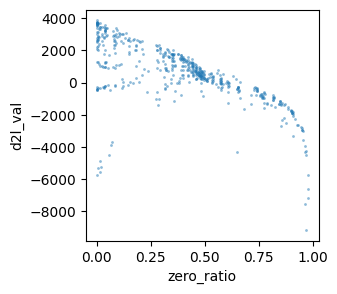

In [25]:
plt.figure(figsize=(3,3))
sns.scatterplot(data = repro_df, x = 'zero_ratio', y = 'd2l_val', s = 4, 
                linewidth=0, alpha=0.5)

In [56]:
bins = [0,0.1,0.3,0.6,0.9]

# Only take where copula was run
results_filt = repro_df

results_filt.loc[:, 'rho_bucket'] = pd.cut(abs(results_filt.rho), bins=bins,
                include_lowest=True,
                labels = ['<10%','10%-30%','30%-60%','70%-90%'])
bins = [0,0.2,0.4,0.6,0.8,1]
labels = ['<20%','20%-40%','40%-60%','60%-80%','80%-100%']
results_filt.loc[:, 'zr_cat'] = pd.cut(results_filt.zero_ratio, bins=bins,
                include_lowest=True,
                labels = labels
                )
results_filt.loc[:, 'zz_cat'] = pd.cut(results_filt.zz_ratio, bins=bins,
                include_lowest=True,
                labels = labels)

In [77]:
counts = results_filt.groupby(['zr_cat', 'stable'])['stable'].value_counts()
df1 = results_filt.groupby(['zr_cat', 'stable'])['stable'].value_counts().reset_index()
df1['stable_frac'] = counts.groupby(level=0).apply(lambda x:  x / float(x.sum())).values

In [79]:
counts = results_filt.groupby(['zz_cat', 'stable'])['stable'].value_counts()
df2 = results_filt.groupby(['zz_cat', 'stable'])['stable'].value_counts().reset_index()
df2['stable_frac'] = counts.groupby(level=0).apply(lambda x:  x / float(x.sum())).values

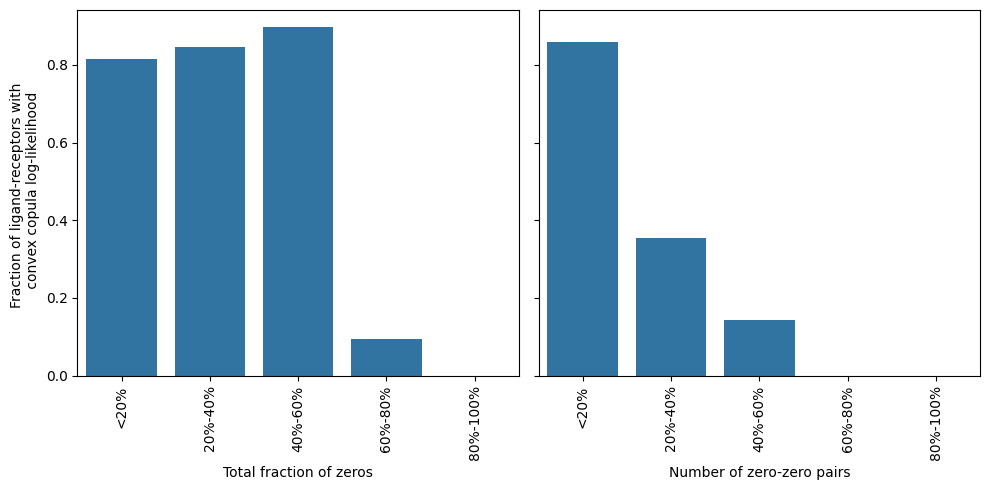

In [113]:
fig, ax = plt.subplots(1,2, figsize=(10,5),sharey=True)
sns.barplot(
    data = df1.loc[df1.stable],
    x = 'zr_cat',
    y = 'stable_frac',
    ax=ax[0]
)

sns.barplot(
    data = df2.loc[df2.stable],
    x = 'zz_cat',
    y = 'stable_frac',
    ax=ax[1]
)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
ax[0].set_xlabel('Total fraction of zeros')
ax[0].set_ylabel('Fraction of ligand-receptors with \n convex copula log-likelihood')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
ax[1].set_xlabel('Number of zero-zero pairs')
plt.xticks(rotation=90) 
plt.tight_layout()

<Axes: xlabel='zr_cat', ylabel='stable_frac'>

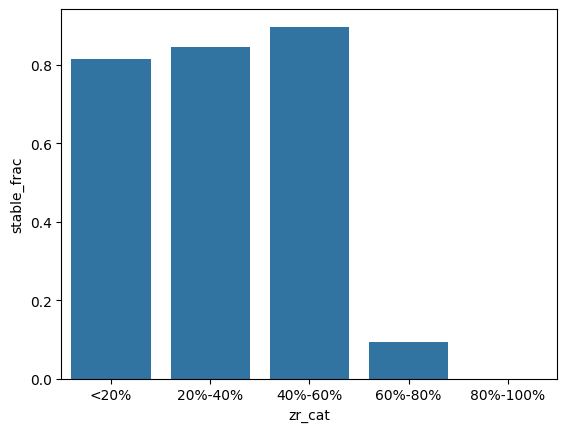

In [97]:
sns.barplot(data=df1.loc[df1.stable], x = 'zr_cat', y='stable_frac')

In [54]:
counts = results_filt.groupby(['zr_cat', 'stable'])['stable'].value_counts()

In [55]:
counts.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

zr_cat    zr_cat    stable
<10%      <10%      False     21.052632
                    True      78.947368
10%-30%   10%-30%   False     14.516129
                    True      85.483871
30%-100%  30%-100%  False     39.197531
                    True      60.802469
Name: count, dtype: float64